In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import pickle

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Loading Data set


In [2]:
data  = pd.read_csv('preprocessed_data.csv',nrows=35000)
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [4]:
X=data.drop(['project_is_approved'],axis=1)
Y=data['project_is_approved'].values

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,stratify=Y,random_state=42)

X_train.shape,'train-x',Y_train.shape,'train-y',X_test.shape,'test-x',Y_test.shape,'test-y'

((23450, 8),
 'train-x',
 (23450,),
 'train-y',
 (11550, 8),
 'test-x',
 (11550,),
 'test-y')

# 2. Categorical data set handling

### 2.1 Response coding

In [5]:
# https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data
def response_coding(xtrain, ytrain, feature):   
    
    from prettytable import PrettyTable
    dictionary = dict()
    x = PrettyTable()
    x = PrettyTable([feature, 'class 1', 'class 0'])

    unique_cat_labels = xtrain[feature].unique()

    for i in tqdm(range(len(unique_cat_labels))):
        total_count = xtrain.loc[:,feature][(xtrain[feature] == unique_cat_labels[i])].count()
        p_0 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==0))].count()
        p_1 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==1))].count()

        dictionary[unique_cat_labels[i]] = [p_1/total_count, p_0/total_count]

        row = []
        row.append(unique_cat_labels[i])
        row.append(p_1/total_count)
        row.append(p_0/total_count)
        x.add_row(row)
    #print()
    print(x)#[![enter image description here][1]][1]
    return dictionary

grade=response_coding(X_train,Y_train,'project_grade_category')
school_state=response_coding(X_train,Y_train,'school_state')
teacher_pre=response_coding(X_train,Y_train,'teacher_prefix')
cate=response_coding(X_train,Y_train,'clean_categories')
subcate=response_coding(X_train,Y_train,'clean_subcategories')

 39%|███████████████████████████████▊                                                 | 20/51 [00:00<00:00, 194.61it/s]

+------------------------+--------------------+---------------------+
| project_grade_category |      class 1       |       class 0       |
+------------------------+--------------------+---------------------+
|       grades_3_5       | 0.8530190344132106 | 0.14698096558678936 |
|       grades_6_8       | 0.8352322524101665 | 0.16476774758983348 |
|      grades_9_12       | 0.8461538461538461 | 0.15384615384615385 |
|     grades_prek_2      | 0.8453110865413609 | 0.15468891345863905 |
+------------------------+--------------------+---------------------+


 49%|███████████████████████████████████████▌                                         | 21/43 [00:00<00:00, 200.45it/s]

+--------------+--------------------+----------------------+
| school_state |      class 1       |       class 0        |
+--------------+--------------------+----------------------+
|      in      | 0.8613861386138614 | 0.13861386138613863  |
|      ny      | 0.8614130434782609 | 0.13858695652173914  |
|      sc      | 0.8513824884792627 | 0.14861751152073732  |
|      tn      | 0.8489702517162472 | 0.15102974828375287  |
|      nc      | 0.8397129186602871 | 0.16028708133971292  |
|      ca      | 0.8696081659532433 | 0.13039183404675667  |
|      la      | 0.800531914893617  | 0.19946808510638298  |
|      ma      | 0.833648393194707  |  0.166351606805293   |
|      tx      | 0.8045454545454546 | 0.19545454545454546  |
|      co      | 0.8207171314741036 | 0.17928286852589642  |
|      mi      | 0.8421828908554573 | 0.15781710914454278  |
|      ut      | 0.849624060150376  | 0.15037593984962405  |
|      mo      | 0.8690095846645367 | 0.13099041533546327  |
|      fl      |  0.8436

  7%|█████▌                                                                          | 22/318 [00:00<00:01, 214.16it/s]

+-----------------------------------+--------------------+----------------------+
|          clean_categories         |      class 1       |       class 0        |
+-----------------------------------+--------------------+----------------------+
|           health_sports           | 0.8555090655509066 | 0.14449093444909344  |
|            math_science           | 0.817046518888542  |  0.182953481111458   |
|             music_arts            | 0.8656084656084656 |  0.1343915343915344  |
|         literacy_language         | 0.8590004063388866 | 0.14099959366111336  |
|   math_science literacy_language  | 0.8620689655172413 | 0.13793103448275862  |
|    math_science history_civics    |       0.875        |        0.125         |
|   literacy_language math_science  | 0.8617807778849245 | 0.13821922211507554  |
|    appliedlearning specialneeds   | 0.8051948051948052 | 0.19480519480519481  |
|    appliedlearning math_science   | 0.8010204081632653 |  0.1989795918367347  |
|           hist

100%|███████████████████████████████████████████████████████████████████████████████| 318/318 [00:01<00:00, 199.16it/s]

+-----------------------------------------+--------------------+----------------------+
|           clean_subcategories           |      class 1       |       class 0        |
+-----------------------------------------+--------------------+----------------------+
|             health_wellness             | 0.8756944444444444 | 0.12430555555555556  |
| environmentalscience health_lifescience |        0.79        |         0.21         |
|                visualarts               | 0.8449197860962567 | 0.15508021390374332  |
|               esl literacy              | 0.8509615384615384 | 0.14903846153846154  |
|                 literacy                | 0.8862433862433863 | 0.11375661375661375  |
|        performingarts visualarts        | 0.7391304347826086 |  0.2608695652173913  |
|            literature_writing           | 0.8474923234390993 | 0.15250767656090072  |
|  health_lifescience literature_writing  | 0.8775510204081632 | 0.12244897959183673  |
|   health_lifescience history_g

### 2.2 Coding for replacment of the words to values

In [6]:
def replace(data_frame,feature,dic):
    #creating two feature 0 & 1
    df=data_frame.copy()
    u=list(df[feature].unique())# for test data set unique category
    df[feature+'_0']=df[feature]
    df=df.rename(columns={feature:feature+'_1'})
    col=np.array(df.columns)
    ind_col=np.where(col == feature+'_1')[0][0]
    cols=list(df.columns)
    df=df[cols[0:ind_col]+[cols[-1]]+cols[ind_col:len(cols)-1]]
    
    # Using the dict for replacing the values
    for i in tqdm(dic):
        temp=dic[i]
        df[feature+'_0']=df[feature+'_0'].replace(i,temp[1])
        df[feature+'_1']=df[feature+'_1'].replace(i,temp[0])
     
    # Test data set new category
    keys=list(dic.keys())
    for i in keys:
        try:
            u.remove(i)
        except:
            print("This element is not present in train data set=",i)
            for i in u:
                df[feature+'_0']=df[feature+'_0'].replace(i,0.5)
                df[feature+'_1']=df[feature+'_1'].replace(i,0.5)
    
    return df


# Train data set
d=X_train.drop(['teacher_number_of_previously_posted_projects','essay','price'],axis=1)
df=replace(d,'project_grade_category',grade)
df1=replace(df,'school_state',school_state)
df2=replace(df1,'teacher_prefix',teacher_pre)
df3=replace(df2,'clean_categories',cate)
X_cat_train=replace(df3,'clean_subcategories',subcate)

# Test data set
d=X_test.drop(['teacher_number_of_previously_posted_projects','essay','price'],axis=1)
df=replace(d,'project_grade_category',grade)
df1=replace(df,'school_state',school_state)
df2=replace(df1,'teacher_prefix',teacher_pre)
df3=replace(df2,'clean_categories',cate)
X_cat_test=replace(df3,'clean_subcategories',subcate)


#replace(X_test,'clean_categories',cate)

 12%|█████████▋                                                                         | 5/43 [00:00<00:01, 35.08it/s]

This element is not present in train data set= dr


  3%|██▎                                                                               | 9/318 [00:00<00:03, 77.79it/s]

This element is not present in train data set= music_arts appliedlearning
This element is not present in train data set= history_civics health_sports


100%|████████████████████████████████████████████████████████████████████████████████| 318/318 [00:23<00:00, 13.67it/s]


This element is not present in train data set= environmentalscience gym_fitness
This element is not present in train data set= performingarts specialneeds
This element is not present in train data set= economics other
This element is not present in train data set= appliedsciences parentinvolvement
This element is not present in train data set= environmentalscience other
This element is not present in train data set= history_geography other
This element is not present in train data set= gym_fitness music
This element is not present in train data set= nutritioneducation visualarts
This element is not present in train data set= charactereducation financialliteracy
This element is not present in train data set= environmentalscience foreignlanguages
This element is not present in train data set= college_careerprep nutritioneducation
This element is not present in train data set= earlydevelopment teamsports
This element is not present in train data set= history_geography performingarts
This 

### 2.3 Words vectorization

In [7]:
train_essays = X_train['essay'].values
test_essays = X_test['essay'].values

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10)     #taking words which has been appeared in at least 10 doc (min_df=10)
vectorizer_tfidf=vectorizer_tfidf.fit(train_essays)
train_text_tfidf = vectorizer_tfidf.transform(train_essays)
test_text_tfidf = vectorizer_tfidf.transform(test_essays)
words_dict = vectorizer_tfidf.vocabulary_
print("Shape of matrix after one hot encodig train and test",train_text_tfidf.shape,test_text_tfidf.shape)

Shape of matrix after one hot encodig train and test (23450, 8943) (11550, 8943)


#### 2.3.1 W2V

In [9]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [11]:
# average Word2Vec
# compute average word2vec for each review.

def avg_w2v_vectors(data):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

train_w2v=np.array(avg_w2v_vectors(train_essays))
test_w2v=np.array(avg_w2v_vectors(test_essays))

train_w2v.shape,test_w2v.shape

100%|██████████████████████████████████████████████████████████████████████████| 11550/11550 [00:03<00:00, 3739.16it/s]


((23450, 300), (11550, 300))

#### 2.3.2 Sentiment

In [12]:
sid = SentimentIntensityAnalyzer()

def analyzer(data):
    neg=[]
    neu=[]
    pos=[]
    compound=[]
    for i in tqdm(data):
        s=sid.polarity_scores(i)
        neg.append(s['neg'])
        neu.append(s['neu'])
        pos.append(s['pos'])
        compound.append(s['compound'])
    
    return neg,neu,pos,compound 
    
neg,neu,pos,compound=analyzer(train_essays)
neg_test,neu_test,pos_test,compound_test=analyzer(test_essays) 

100%|███████████████████████████████████████████████████████████████████████████| 11550/11550 [00:25<00:00, 452.34it/s]


In [13]:
neg=np.reshape(neg,(-1,1))
neu=np.reshape(neu,(-1,1))
pos=np.reshape(pos,(-1,1))
compound=np.reshape(compound,(-1,1))


neg_test=np.reshape(neg_test,(-1,1))
neu_test=np.reshape(neu_test,(-1,1))
pos_test=np.reshape(pos_test,(-1,1))
compound_test=np.reshape(compound_test,(-1,1))

### 2.4 Numerical features

In [14]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_num_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_num_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

# 3. Data set 1

In [15]:
from scipy.sparse import hstack
X_tr = hstack((train_text_tfidf ,  X_cat_train , X_train_price_norm , X_train_num_norm , neg , neu , pos , compound)).tocsr()
X_te = hstack((test_text_tfidf , X_cat_test , X_test_price_norm , X_test_num_norm , neg_test , neu_test , pos_test , compound_test)).tocsr()

print(X_tr.get_shape(),"shape of training data set")
print(X_te.get_shape(),"shape of testing data set")



(23450, 8959) shape of training data set
(11550, 8959) shape of testing data set


### 3.1 Finding the best hyperparameters

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# https://stackoverflow.com/questions/37689942/grid-search-finding-parameters-for-auc

DB = GradientBoostingClassifier(random_state=0)

parameters={'max_depth':[1, 2, 3, 4],
            "n_estimators":[5,10,15,20] }

clf = GridSearchCV(DB, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

%time clf.fit(X_tr,Y_train)

Wall time: 3min 51s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [17]:
from sklearn.metrics import roc_auc_score
print(clf.best_params_)
print(clf.best_score_)

Y_pred=clf.predict_proba(X_te)[:,1]
roc_auc_score(Y_test,Y_pred)

{'max_depth': 4, 'n_estimators': 20}
0.6693683391153492


0.6551416041078073

### 3.2 Plotting heat map of parameters and there outputs

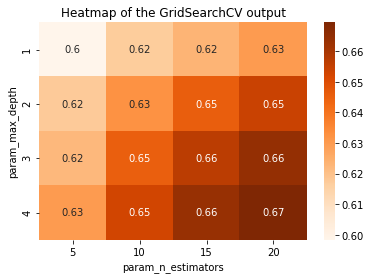

In [18]:
import seaborn as sns
x=clf.cv_results_['param_n_estimators'].data
y=clf.cv_results_['param_max_depth'].data
z=clf.cv_results_['mean_test_score']

mat=np.zeros((4,4))
for i in range(len(z)):
    mat.itemset(i, z[i])


ax= plt.subplot();
sns.heatmap(mat, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('param_n_estimators');ax.set_ylabel('param_max_depth'); 
ax.set_title('Heatmap of the GridSearchCV output');
ax.xaxis.set_ticklabels(['5','10','15','20']); 
ax.yaxis.set_ticklabels(['1','2','3','4']);


### 3.3 Training the best model

In [19]:
from sklearn.metrics import confusion_matrix

DB_best = GradientBoostingClassifier(random_state=0,max_depth= 4,n_estimators= 20)
DB_best.fit(X_tr,Y_train)


GradientBoostingClassifier(max_depth=4, n_estimators=20, random_state=0)

### 3.4 AUC

test=  0.6551416041078073
train=  0.745515594373414


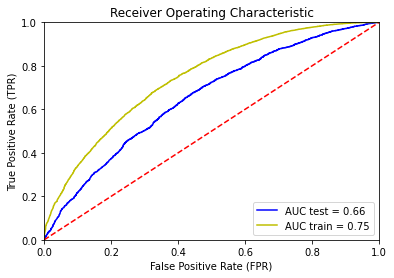

In [22]:
y_pred=DB_best.predict_proba(X_te)[:,1]    # predict the probabitity of class 1 = (approved)
print("test= ",metrics.roc_auc_score(Y_test, y_pred))
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
roc_auc_test = metrics.auc(fpr, tpr)

y_pred_class_train = DB_best.predict_proba(X_tr)[:,1]   # predict the probabitity of class 1 = (approved)
print("train= ",metrics.roc_auc_score(Y_train, y_pred_class_train))
fpr_1, tpr_1, threshold_1 = metrics.roc_curve(Y_train, y_pred_class_train)
roc_auc_train = metrics.auc(fpr_1, tpr_1)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC test = %0.2f' % roc_auc_test)
plt.plot(fpr_1, tpr_1, 'y', label = 'AUC train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

### 3.5 confusion matrix 

Train data set

[[   35  3564]
 [    0 19851]]


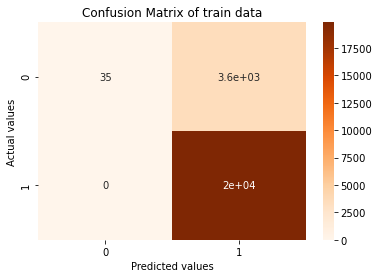

In [24]:
import seaborn as sns

y_pred_bi=DB_best.predict(X_tr)
cf_matrix=confusion_matrix(Y_train,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of train data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

Test data set

[[   7 1765]
 [   5 9773]]


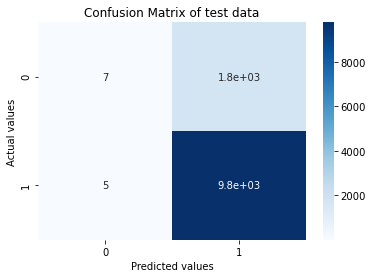

In [25]:
y_pred_bi=DB_best.predict(X_te)
cf_matrix=confusion_matrix(Y_test,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of test data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

# 4. Data set 2

In [35]:
from scipy.sparse import hstack


X_tr_2 = np.column_stack((train_w2v ,X_cat_train , X_train_price_norm , X_train_num_norm , neg , neu , pos , compound))
X_te_2 = np.column_stack((test_w2v , X_cat_test , X_test_price_norm , X_test_num_norm , neg_test , neu_test , pos_test , compound_test))

print(X_tr_2.shape,"shape of training data set")
print(X_te_2.shape,"shape of testing data set")

(23450, 316) shape of training data set
(11550, 316) shape of testing data set


### 4.1 Finding the best hyperparameter

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# https://stackoverflow.com/questions/37689942/grid-search-finding-parameters-for-auc

DB_2 = GradientBoostingClassifier(random_state=0)

parameters={'max_depth':[1, 2, 3, 4],
            "n_estimators":[5,10,15,20] }

clf = GridSearchCV(DB_2, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

%time clf.fit(X_tr_2,Y_train)

Wall time: 8min 1s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [39]:
from sklearn.metrics import roc_auc_score
print(clf.best_params_)
print(clf.best_score_)

Y_pred=clf.predict_proba(X_te_2)[:,1]
roc_auc_score(Y_test,Y_pred)

{'max_depth': 4, 'n_estimators': 20}
0.6680806998246132


0.6642239315513196

### 4.2 Heatmap of hyperparameter

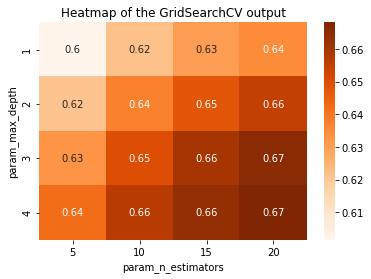

In [40]:
import seaborn as sns
x=clf.cv_results_['param_n_estimators'].data
y=clf.cv_results_['param_max_depth'].data
z=clf.cv_results_['mean_test_score']

mat=np.zeros((4,4))
for i in range(len(z)):
    mat.itemset(i, z[i])


ax= plt.subplot();
sns.heatmap(mat, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('param_n_estimators');ax.set_ylabel('param_max_depth'); 
ax.set_title('Heatmap of the GridSearchCV output');
ax.xaxis.set_ticklabels(['5','10','15','20']); 
ax.yaxis.set_ticklabels(['1','2','3','4']);


### 4.3 Confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix

DB_best = GradientBoostingClassifier(random_state=0,max_depth= 4,n_estimators= 20)
DB_best.fit(X_tr_2,Y_train)


GradientBoostingClassifier(max_depth=4, n_estimators=20, random_state=0)

### 4.4 AUC

test=  0.6642239315513196
train=  0.7479904225070833


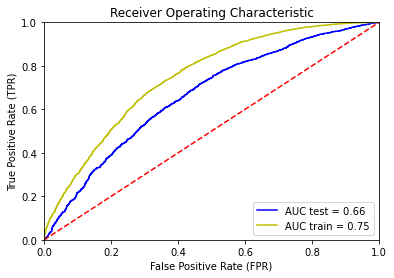

In [43]:
y_pred=DB_best.predict_proba(X_te_2)[:,1]    # predict the probabitity of class 1 = (approved)
print("test= ",metrics.roc_auc_score(Y_test, y_pred))
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
roc_auc_test = metrics.auc(fpr, tpr)

y_pred_class_train = DB_best.predict_proba(X_tr_2)[:,1]   # predict the probabitity of class 1 = (approved)
print("train= ",metrics.roc_auc_score(Y_train, y_pred_class_train))
fpr_1, tpr_1, threshold_1 = metrics.roc_curve(Y_train, y_pred_class_train)
roc_auc_train = metrics.auc(fpr_1, tpr_1)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC test = %0.2f' % roc_auc_test)
plt.plot(fpr_1, tpr_1, 'y', label = 'AUC train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

### 4.5 Confusion matrix

Train data set

[[   35  3564]
 [    0 19851]]


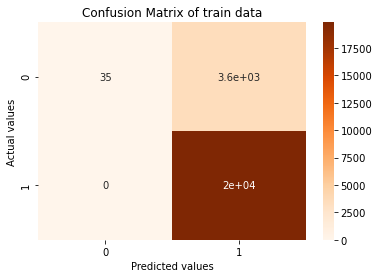

In [44]:
import seaborn as sns

y_pred_bi=DB_best.predict(X_tr_2)
cf_matrix=confusion_matrix(Y_train,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of train data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

Test data set

[[   6 1766]
 [   6 9772]]


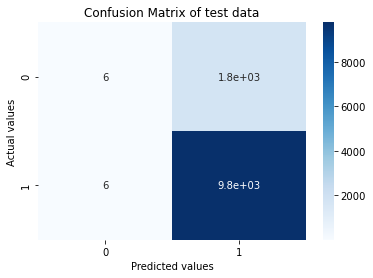

In [45]:
y_pred_bi=DB_best.predict(X_te_2)
cf_matrix=confusion_matrix(Y_test,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of test data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

# 5. Outputs 

In [54]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter(max depth)","hyper parameter(n_estimators) ","AUC"]
x.add_row(["TFIDF", "GBDT", 4,20, 0.6551416041078073])
x.add_row(["TFIDF W2V", "GBDT", 4,20, 0.6642239315513196])
print(x)

+------------+-------+----------------------------+--------------------------------+--------------------+
| Vectorizer | Model | Hyper parameter(max depth) | hyper parameter(n_estimators)  |        AUC         |
+------------+-------+----------------------------+--------------------------------+--------------------+
|   TFIDF    |  GBDT |             4              |               20               | 0.6551416041078073 |
| TFIDF W2V  |  GBDT |             4              |               20               | 0.6642239315513196 |
+------------+-------+----------------------------+--------------------------------+--------------------+
